# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np

from src.Inference import Inference
from src.Subspace import Subspace
from src.model import Model
from src.util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [10]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'.\example\hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.73210946091575
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.95458639088457
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.77912591689822
Iteration 1000 lower bound 22.029867169404948; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866593
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.092044

Text(0, 0.5, 'Y')

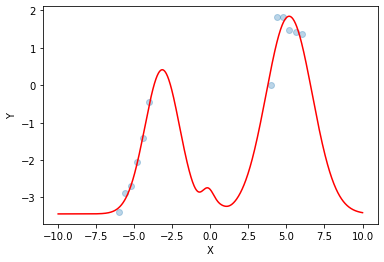

In [11]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y')


In [12]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [13]:
hmc_tune_params={'step_size':1e-3,
                                'leapfrog_steps': 50,
                                'total_samples': 10000,
                                'burn_in': 0.2,
                                'warm_start': False,
                                'thinning_factor': 2,
                                'mom_std': 1,
                                'diagnostic_mode': False}

In [21]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=np.eye(P.shape[0]), w_hat=np.zeros_like(w),  tune_params=hmc_tune_params,
                               , Sigma_Z=5)

In [25]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [ ]:
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,diagnostic_mode=False)#, step_size=1e-2, leapfrog_steps=1000,
              #total_samples=10000, burn_in=0.1, thinning_factor=2, check_point=200)

HMC 200: accept rate of 90.0 with step size 0.001
HMC 400: accept rate of 83.0 with step size 0.0010500000000000002
HMC 600: accept rate of 81.66666666666667 with step size 0.0011025000000000002
HMC 800: accept rate of 80.625 with step size 0.0011576250000000002
HMC 1000: accept rate of 79.9 with step size 0.0012155062500000004
HMC 1200: accept rate of 78.83333333333333 with step size 0.0012155062500000004
HMC 1400: accept rate of 77.57142857142857 with step size 0.0012155062500000004
HMC 1600: accept rate of 77.875 with step size 0.0012155062500000004
HMC 1800: accept rate of 78.05555555555556 with step size 0.0012155062500000004
HMC 200: accept rate of 74.0


In [9]:

# get posterior z
n_sample = 10
post_sample = my_inference.get_posterior(n_samples=n_sample).reshape(-1, 2)
x_test = np.linspace(-8, 8, 100)
y_test = np.reshape(
    [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
    (n_sample, -1)) \
         + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

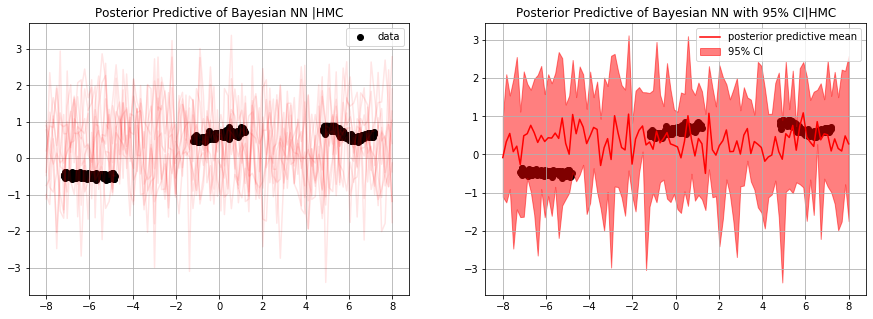

In [10]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test, 0.25, axis=0), np.percentile(y_test, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()